### Importamos las bibliotecas a ocupar
- **OpenCV** para el procesado de imagenes y aplicacion de filtros morfologicos
- **numpy** para las operaciones matriciales
- **skimage** para visualizar las imagenes y aplicar filtros morfologicos

In [1]:
import cv2
import numpy as np
from skimage import io
from skimage.morphology import opening
from skimage.morphology import rectangle

### Funciones a implementar
- **read_img:** funcion que lee las imagenes.
- **get_grey_image:** funcion que extrae un canal de la imagen para aplicar las transformaciones y deteccion de bordes.
- **apply_staggered_filter:** funcion que aplica la operacion espacial, con un alpha base = 27: $$ P_{ij}=\left\lbrace\begin{array}{c} 255~~s\acute{i}~~P_{ij} >alpha \\ P_{ij}~~s\acute{i}~~P_{ij}<=alpha \end{array}\right. $$
- **get_border_canny:** funcion que obtiene los bordes con el operador Canny como nucleo de las operaciones.
- **get_border_kernel:** funcion que obtiene los bordes con filtros morfologicos como nucleo de las operaciones.
- **get_border_degree_canny:** funcion que obtiene los bordes con un filtros de sobel y canny aplicado al gradiente de la imagen.

In [2]:
def read_img(url, grey=False):
    """
    Metodo que carga la imagen.
    Parameters
    ----------
    url : string 
        ruta donde se encuentra la imagen.
    grey : boolean
        valor que indica si se lee la imagen a color o en blanco y negro
    Returns
    ----------
    Retorna la imagen en formato RGB
    """
    image = cv2.imread(url,cv2.IMREAD_UNCHANGED)#cv2.IMREAD_UNCHANGED
    if grey:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)# COLOR_BGR2GRAY/COLOR_BGR2RGB
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def get_grey_image(image):
    """
    Metodo que extra un solo canal de la imagen en caso de que esta posea mas de 1 solo, 
    en caso contrario devuelve la imagen sin modificarla.
    Parameters
    ----------
    image : numpy array 
        imagen a extraer el canal.
    Returns
    ----------
    Canal de la imagen a ocupar.
    """
    if len(image.shape)==2:
        return image
    
    canalR, canalG, canalB = cv2.split(image)
    #evaluamos que canal es mejor ocupar o si se convierte la imagen a GREY
    return canalR

def apply_staggered_filter(image,alpha):
    """
    Metodo que aplica una funcion definida a trozos donde los valores mayores a alpha son elevados a 255.
    Parameters
    ----------
    image : numpy array 
        imagen a aplicar el filtro.
    grey : alpha
        valor que separa el division.
        - valores mayores a alpha son llevados a 255.
        - valores menores a alpha se mantienen intactos.
    Returns
    ----------
    Retorna la imagen con los valores reescalados
    """
    stagg_func = lambda p: 255 if p > alpha else p
    vfunc = np.vectorize(stagg_func,otypes=[np.uint8])
    return vfunc(image)
    

def get_border_canny(image,minMax=(80,90)):
    """
    Metodo que obtiene obtiene los bordes con el operador Canny.
    ----------
    image : numpy array 
        imagen a aplicar el filtro.
    minMax : tupla(int,int)
        valores minimo y maximo de de error respectivamente.
    Returns
    ----------
    image:
        la imagen con los bordes aplicados.
    canny:
        el borde obtenido.
    """
    image_pro = get_grey_image(image)
    
    canny = cv2.Canny(image_pro, minMax[0],minMax[1])
    canny = opening(image=canny, selem=rectangle(2,1) )
    
    contornos,_ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contornos,-1,(255,0,0), 2)
    return image,canny

def get_border_kernel(image, channels='RGB',alpha=27):
    """
    Metodo que obtiene obtiene los bordes con el filtros morfologicos de apertura y gradiente.
    ----------
    image : numpy array 
        imagen a aplicar el filtro.
    channels: string
        formato de la imagen, puede ser RGB o BRG.
    alpha : int
        valor para aplicar el metodo apply_staggered_filter.
    Returns
    ----------
    image:
        la imagen con los bordes aplicados.
    canny:
        el borde obtenido.
    """
    image_pro = get_grey_image(image)
    
    kernels=[(3,3),(5,6),(7,7)]
    for kernelSize in kernels:
        kernel=cv2.getStructuringElement(cv2.MORPH_RECT,kernelSize)
        abierta=cv2.morphologyEx(image_pro, cv2.MORPH_OPEN,kernel)

    kernels = [(2, 2), (4, 4), (5, 5),(9,9)]
    for kernelSize in kernels:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
        gradiente = cv2.morphologyEx(abierta, cv2.MORPH_GRADIENT, kernel)
    
    gaussiana = cv2.GaussianBlur(gradiente, (1, 7), cv2.BORDER_DEFAULT)
    gaussiana = cv2.erode(gaussiana,np.ones((5,1),np.uint8),iterations = 2)
    gaussiana = cv2.erode(gaussiana,np.ones((2,3),np.uint8),iterations = 2)
    gaussiana = apply_staggered_filter(gaussiana,alpha)
    
    if len(image.shape)==3:
        index = channels.index('R')
        image[:,:,index]= cv2.add(image[:,:,index],gaussiana)
    else:
        image = cv2.add(image,gaussiana)
    
    return image,gaussiana

def get_border_degree_canny(image):
    """
    Metodo que obtiene obtiene los bordes con la apliacion del filtro de Sobel 
    para el calculo y aplicacion del gradiente sobre la imagen,
    para luego aplicar Canny sobre el resultado de la operacion anterior.
    ----------
    image : numpy array 
        imagen a aplicar el filtro.
    Returns
    ----------
    image:
        la imagen con los bordes aplicados.
    border:
        el borde obtenido.
    """
    
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    img = cv2.GaussianBlur(img, (5, 5), 0)   
    
    sobel_x = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 5)
    sobel_y = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 5)
    
    border, ang = cv2.cartToPolar(sobel_x, sobel_y, angleInDegrees = True)
    mag_max = np.max(border)
    
    weak_th = mag_max * 0.1
    strong_th = mag_max * 0.5
      
    height, width = img.shape
    angle = 22.5
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            if grad_ang<= angle:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            elif grad_ang>angle and grad_ang<=(angle + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            elif grad_ang>(angle + 45) and grad_ang<=(angle + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            elif grad_ang>(angle + 90) and grad_ang<=(angle + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            elif grad_ang>(angle + 135) and grad_ang<=(angle + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            if width>neighb_1_x >= 0 and height>neighb_1_y>= 0:
                if border[i_y, i_x]<border[neighb_1_y, neighb_1_x]:
                    border[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if border[i_y, i_x]<border[neighb_2_y, neighb_2_x]:
                    border[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = border[i_y, i_x]
              
            if grad_mag < weak_th:
                border[i_y, i_x]= 0
            elif strong_th > grad_mag >= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
       
    border = cv2.normalize(src=border, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    border = opening(image=border, selem=rectangle(2,1) )
    
    (contornos,_) = cv2.findContours(border.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contornos,-1,(255,0,0), 2)
    
    return image,border

### Prueba 1: aplicacion de Canny 

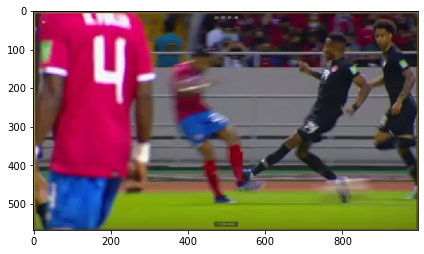

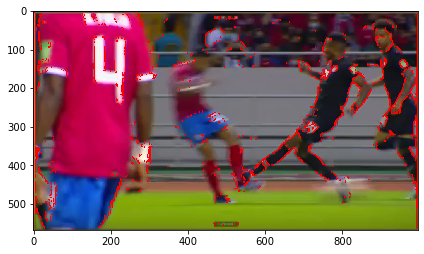

In [3]:
test = read_img("../dataset/VAR1.PNG",grey=False)
io.imshow(test)
io.show()
im_test,border =get_border_canny(test)
io.imshow(im_test)

### Prueba 2: Aplicacion de sobel, gradiente y Canny

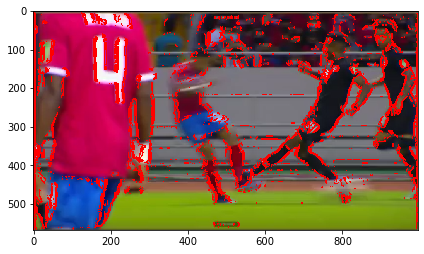

In [4]:
test = read_img("../dataset/VAR1.PNG",grey=False)
canny_img,border = get_border_degree_canny(test)
io.imshow(canny_img)

### Prueba 3: Aplicacion de filtros morfologicos con gradiente

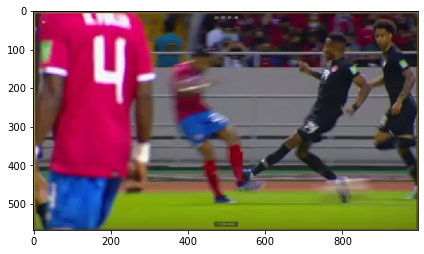

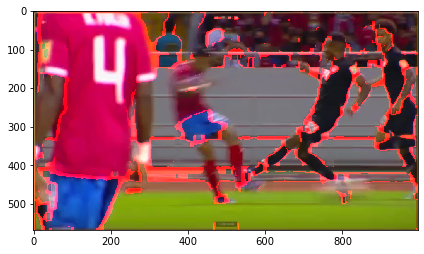

In [5]:
test = read_img("../dataset/VAR1.PNG",grey=False)
io.imshow(test)
io.show()
im_test,border =get_border_kernel(test)
io.imshow(im_test)